# Create handwritten digits with GANs 


The <a href="https://arxiv.org/abs/1406.2661">GAN or Generative Adversarial Networks</a> are one of the latest advances in Deep Learning, the principle is quite simple. Instead of having one model that will generate images, we're going to have two models: 

* **A generator** : The first one is going to try to create images from the image dataset we give it. 
* **A discriminator**: Another model will try to distinguish the images created by the generator from the real images.

Everything is then a battle between the generator which will try to create images so perfect that the discriminator can no longer distinguish _true_ images from _generated_ images.

Let's try to implement this on MNIST: 

<img src="https://tensorflow.org/images/gan/dcgan.gif" />

In [1]:
import tensorflow as tf 
import glob 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import time 
from IPython import display

We need to download the MNIST dataset. You can do this via [`tf.keras.datasets.mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Let's look at an element from `X_train`

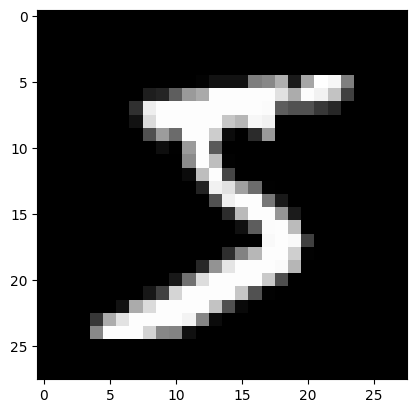

In [3]:
plt.imshow(X_train[0], cmap="gray")

In [4]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

The values for the pixels in the image are reprensented by integer values between 0 and 255, let's normalize our data.

In [5]:
X_train = X_train * 1 / 255

The dimension is `(batch_size, height, width)` which is not suitable for use in tensorflow models, images need to have an additionnal dimension for the channel.

In [6]:
X_train = tf.expand_dims(X_train, axis=-1)

Let's now transform this collection of tensors into a collection of batches

In [7]:
BATCH_SIZE = 256

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X_train)).batch(BATCH_SIZE)

# Generator model

We create a generator model with an input shape of `100`, which means we will feed this model a vector of 100 random values (basically noise) and the model will have to output a tensor that has the same shape as our real data `(1,28,28,1)`.

To achieve this we will use a new layer: `tf.keras.kayers.Conv2DTranspose` that is able to expand the input.

In [9]:
noise_dim = 100

generator = tf.keras.Sequential([
  tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Reshape((7,7, 256)),
  tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False), # does not change the shape because of the stride of 1
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False), # multiplies width and height by 2 thanks to stride 2
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="sigmoid") # multiplies width and height by 2 thanks to stride 2
  ])

Let's look at the details of this architecture

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        294912    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

Now let's generate some random noise and feed it to this model to see what happens!

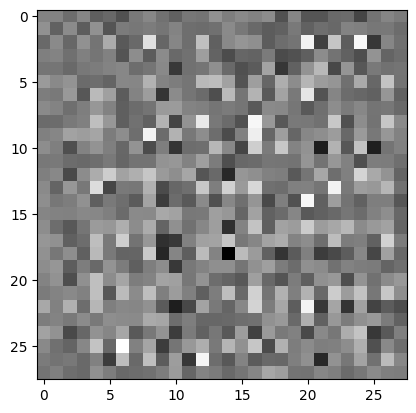

In [11]:
### Random pixel size creation (1, 100)
random_pixels = tf.random.normal([1,100])

### Model application
rand_img = generator(random_pixels, training=False)

### Model visualisation
plt.imshow(rand_img.numpy().squeeze(), cmap="gray")

# Discriminator

The discriminator model is just a convolutional neural network classifier, let's build this model:

In [12]:
discriminator = tf.keras.Sequential([        
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2,2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")      
    ])

# Loss functions

In order to build our loss functions we need to convert this unsupervised problem into a supervised one by assigning target values to real data and fake data on the fly. We will assign label `0` to fake data and `1` to real data for the discriminator loss, and `1` to fake data for the generator loss.

For this we will use two functions `tf.ones_like` and `tf.zeros_like`

In [13]:
# let's create a tensor
t = tf.constant([[1,2],[3,4]])
print("original tensor:", t)

ones = tf.ones_like(t)
print("\n ones like:", ones)

zeros = tf.zeros_like(t)
print("\n zeros like:", zeros)

original tensor: tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)

 ones like: tf.Tensor(
[[1 1]
 [1 1]], shape=(2, 2), dtype=int32)

 zeros like: tf.Tensor(
[[0 0]
 [0 0]], shape=(2, 2), dtype=int32)


## Discriminator loss

Let's define the discriminator loss:

In [14]:
bce = tf.keras.losses.BinaryCrossentropy()

# It can be useful to add some noise on the labels asociated with the real outputs
# and fake outputs. This serves multiple purposes:
# We do not want the discriminator to learn to detect the real images too quickly
# otherwise the generator will not be able to learn.
# It may also be useful to add noise to the fake labels for the same reason
# This is called label smoothing and may serve as regularization for the GAN's 
# training process, leading to more stable results

def discriminator_loss(real_outputs, fake_outputs):
  real_label = tf.ones_like(real_outputs) - 0.05 * tf.random.uniform(shape=real_outputs.shape)
  real_loss = bce(real_label, real_outputs) # for real data disc is expected to predict 1
  fake_label = tf.zeros_like(fake_outputs) + 0.05 * tf.random.uniform(shape=fake_outputs.shape)
  fake_loss = bce(fake_label, fake_outputs) # for fake data disc is expected to predict 0
  
  total_loss = real_loss + fake_loss # the disc loss is the sum of those two losses
  # ability to catch the fake + ability to clear the real data
  return total_loss

## Generator loss

Let's define the generator loss

In [15]:
# We do use label smoothing for the generator model because we want it to perform
# as good as possible.
def generator_loss(fake_outputs):
  return bce(tf.ones_like(fake_outputs), fake_outputs) # gen wants disc to think fake data is real (predicted as 1)

# Prepare the model for custom training

Now let's prepare the model for training, since we have two different models to train, we need two different optimizers.
Adam is usually a good choice for most deep learning models, however, GANs are very sensitive models and sometimes other training algorithms like `tf.keras.optimizers.RMSprop` can be a better choice!

Note that the more difficult the distribution to model, the more sensitive to hyperparameters the model will become.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

## Custom training (General)

Before we study the specific training loop for the GANs let's give a simple example of how it works in general.

We will need a model, an optimizer, a loss function, and something new the `tf.GradientTape()` class, which will be useful for monitoring the gradient of tensorflow functions! (note that it works with any tensorflow operations on tensor, you are not limited certain types of models)

Let's see how it works!

In [17]:
dataset_example = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(128,3,padding="same",input_shape=[X_train.shape[1],X_train.shape[2],1], activation="relu"),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(64,3,padding="same", activation="relu"),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(10, activation="softmax")
])

opt = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

def train_step_example(image_batch, target_batch):
  # this function will tape the gradient inside this 
  with tf.GradientTape() as tape:
    output = model(image_batch) # compute the output
    loss = loss_function(target_batch, output) # compute the loss
    grads = tape.gradient(loss, model.trainable_variables) # calculate the gradient 
    # of the loss along the variables we want to update, we may choose other things
    # than the trainable variables of the model, we can calculate the gradient
    # for any set of variables that influence the loss function, we could for example
    # calculate the gradient along the input values
    opt.apply_gradients(zip(grads, model.trainable_variables)) # use the optimizer
    # to update the variables thanks to the gradient
  return loss

# Training loop
epochs = 1
steps_per_epoch = 10
for epoch in range(epochs):
  for step in range(steps_per_epoch):
    image, target = next(iter(dataset_example))
    loss = train_step_example(image,target)
    print(loss)

tf.Tensor(2.3019166, shape=(), dtype=float32)
tf.Tensor(2.2551773, shape=(), dtype=float32)
tf.Tensor(2.2205343, shape=(), dtype=float32)
tf.Tensor(2.19117, shape=(), dtype=float32)
tf.Tensor(2.154108, shape=(), dtype=float32)
tf.Tensor(2.059886, shape=(), dtype=float32)
tf.Tensor(2.0056791, shape=(), dtype=float32)
tf.Tensor(1.9257212, shape=(), dtype=float32)
tf.Tensor(1.8148293, shape=(), dtype=float32)
tf.Tensor(1.700037, shape=(), dtype=float32)


Now that you know the general principle for custom training, let's apply it to our GAN problem!

## Training Step

Let's now code a function that will compute one gradient descent step on both models simultaneously

In [18]:
def train_step(images): # the function takes a batch of images as argument
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # generate a batch of noise

    # The GradientTape class is able to monitor and record the gradient of a given
    # tensorflow function, we will use it here to calculate the gradients of our
    # loss functions
    # We will need a tape for each of the models
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # generate a batch of fake data
      # the training=True argument is for the batch normalization

      real_output = discriminator(images, training=True) # compute the real outputs from the real data
      fake_output = discriminator(generated_images, training=True) # compute the fake outputs from the fake data

      gen_loss = generator_loss(fake_output) # compute the generator loss
      disc_loss = discriminator_loss(real_output, fake_output) # compute the discriminator loss

      # the tf.GradientTape() .gradient(value, variables) method will calculate the gradient 
      # of a given function at point "value" according to "variables", note that this
      # works because we built everything with tensorflow functions
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # the tf.keras.optimizer .apply_gradients(zip(grad,variables)) method updates the 
      # variables by running variables = variables - learning_rate * grad
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## Utility function

Let's create one last function that will let us visualize the evolution of generated images of a fixed set of noise throughout training.

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training loop

It's finally time to train our model and watch is improve its generation capabilites epoch after epoch!

In [20]:
# Generate the fixed generated examples
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

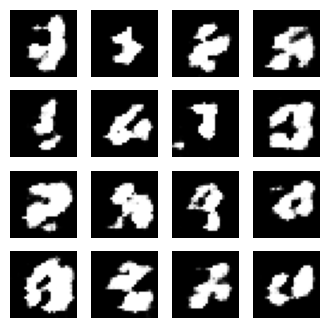

In [22]:
EPOCHS = 1

# loop over the number of epochs that we want to run
for epoch in range(EPOCHS):
  start = time.time()

  # loop over each batch in the source dataset
  for image_batch in dataset:
    # Run a training step to update the parameters in both models
    train_step(image_batch)

  # Remove the previous image 
  display.clear_output(wait=True)
  # Displays the new generated image
  generate_and_save_images(generator,
                           epoch + 1,
                           seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Génère la toute dernière image
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

The results do not look too bad, now you can try playing arount with the hyper parameters, such as the smoothing of the labels etc in order to get more realistic images!